In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [3]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')
spec_file = os.path.join(morph_folder, 'specs_star.p')

# load all dfs

In [123]:
group1_pred = pickle.load(open(os.path.join(results_folder, 'group1_predicted.p'), 'rb'))
group2_pred = pickle.load(open(os.path.join(results_folder, 'group2_predicted.p'), 'rb'))
group3_pred = pickle.load(open(os.path.join(results_folder, 'group3_predicted.p'), 'rb'))
group1_behav = pickle.load(open(os.path.join(results_folder, 'group1_behav_agg.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(results_folder, 'group2_behav_agg.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(results_folder, 'group3_behav_agg.p'), 'rb'))

In [127]:
group1_pred.tail()

,index,min_val,max_val,slope,inflection,group,metric,subj
42,ch,1.068966e-01,0.921299,0.473474,52.398018,Group 1,fcosine,NaN
43,de,3.112033e-03,0.998988,1.826562,56.232209,Group 1,fcosine,NaN
44,df,1.331266e-03,0.999785,0.618558,57.762664,Group 1,fcosine,NaN
45,dg,1.000000e-16,0.998902,0.168912,62.735145,Group 1,fcosine,NaN
46,dh,3.117956e-03,0.640119,0.085617,94.926209,Group 1,fcosine,NaN


In [28]:
all_groups = pd.concat([group1_pred, group2_pred, group3_pred,
                       group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

In [29]:
all_groups = all_groups.drop(columns=['subj'])

(0.0, 1.0)

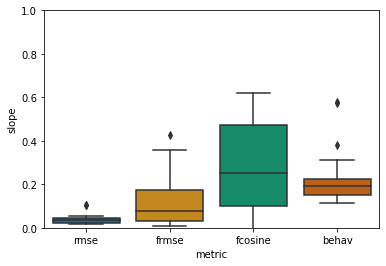

In [10]:
ax = sns.boxplot(y='slope', x='metric',data=all_groups)
ax.set_ylim([0,1])

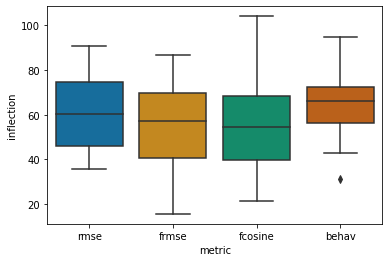

In [11]:
ax = sns.boxplot(y='inflection', x='metric',data=all_groups)

# separate by group

In [30]:
groups = ['Group 1', 'Group 2', 'Group 3']

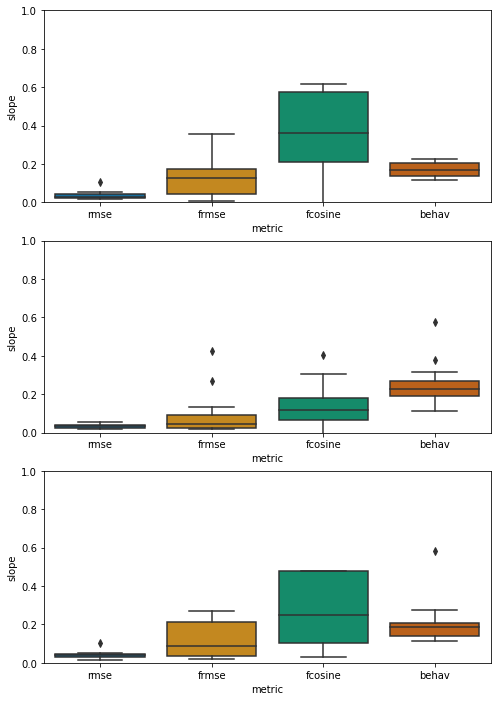

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='slope', x='metric',data=all_groups[all_groups.group==group], ax=ax[i])
    ax[i].set_ylim([0,1])

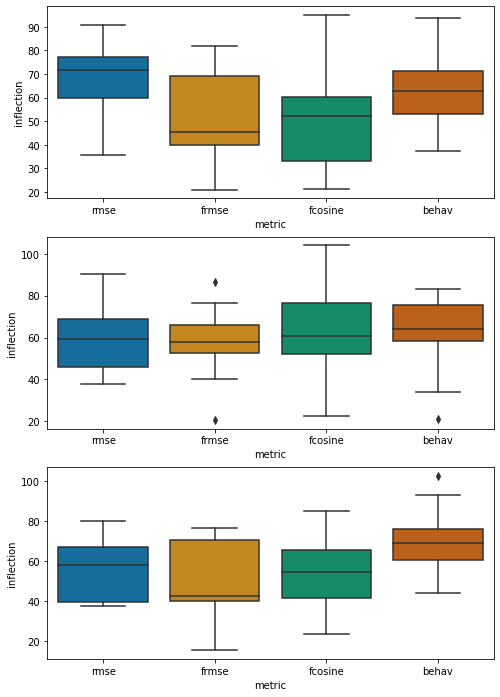

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='inflection', x='metric',data=all_groups[all_groups.group==group], ax=ax[i])

In [14]:
import statsmodels.formula.api as smf

In [21]:
all_groups['stim'] = all_groups['index']

In [22]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric,stim
0,ae,1.000000e-16,1.000000,0.029308,76.226299,Group 1,rmse,ae
1,af,1.000000e-16,0.925953,0.021387,58.667611,Group 1,rmse,af
2,ag,1.000000e-16,0.977344,0.030870,52.000076,Group 1,rmse,ag
3,ah,1.000000e-16,0.795719,0.026042,35.582889,Group 1,rmse,ah
4,be,1.402487e-01,1.000000,0.045282,86.134743,Group 1,rmse,be


In [23]:
all_groups = all_groups.drop(columns=['index'])

In [68]:
model = smf.mixedlm("slope ~ C(group):C(metric, Treatment('behav'))  ",
                    all_groups,
                    groups= "group").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Mixed Linear Model Regression Results
==========================================================================================================
Model:                             MixedLM                  Dependent Variable:                  slope    
No. Observations:                  170                      Method:                              REML     
No. Groups:                        3                        Scale:                               3.9823   
Min. group size:                   52                       Log-Likelihood:                      -349.2194
Max. group size:                   63                       Converged:                           Yes      
Mean group size:                   56.7                                                                   
----------------------------------------------------------------------------------------------------------
                                                           Coef.     Std.Err.     z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                                   0.171         2.057  0.083 0.934 -3.861  4.202
C(metric, Treatment('behav'))[T.fcosine]                    1.919         0.717  2.675 0.007  0.513  3.324
C(metric, Treatment('behav'))[T.frmse]                      0.040         0.706  0.057 0.955 -1.343  1.423
C(metric, Treatment('behav'))[T.rmse]                      -0.135         0.706 -0.192 0.848 -1.518  1.248
C(group)[T.Group 2]:C(metric, Treatment('behav'))[behav]    0.078         2.909  0.027 0.978 -5.623  5.780
C(group)[T.Group 3]:C(metric, Treatment('behav'))[behav]    0.035         2.909  0.012 0.990 -5.667  5.736
C(group)[T.Group 2]:C(metric, Treatment('behav'))[fcosine] -1.857         2.926 -0.635 0.526 -7.592  3.878
C(group)[T.Group 3]:C(metric, Treatment('behav'))[fcosine] -0.179         2.922 -0.061 0.951 -5.906  5.547
C(group)[T.Group 2]:C(metric, Treatment('behav'))[frmse]   -0.111         2.923 -0.038 0.970 -5.841  5.618
C(group)[T.Group 3]:C(metric, Treatment('behav'))[frmse]    0.059         2.919  0.020 0.984 -5.661  5.780
C(group)[T.Group 2]:C(metric, Treatment('behav'))[rmse]    -0.002         2.923 -0.001 0.999 -5.732  5.727
C(group)[T.Group 3]:C(metric, Treatment('behav'))[rmse]     0.005         2.919  0.002 0.999 -5.716  5.726
group Var                                                   3.982 133920342.589                           
==========================================================================================================

"""

In [71]:
model = smf.mixedlm("inflection ~ C(metric)",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    inflection
No. Observations:    170        Method:                REML      
No. Groups:          3          Scale:                 303.9880  
Min. group size:     52         Log-Likelihood:        -717.5474 
Max. group size:     63         Converged:             Yes       
Mean group size:     56.7                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
Intercept             64.139    2.517 25.487 0.000  59.207 69.071
C(metric)[T.fcosine]  -8.800    3.737 -2.355 0.019 -16.124 -1.475
C(metric)[T.frmse]   -10.732    3.715 -2.889 0.004 -18.013 -3.451
C(metric)[T.rmse]     -2.567    3.715 -0.691 0.490  -9.848  4.714
group Var              0.000    0.415                            
=================================================================

"""

# paired t test

In [35]:
from scipy.stats import ttest_rel

In [31]:
group3_df = all_groups[all_groups.group=='Group 3'].reset_index(drop=True)
slope_df = group3_df.pivot(index='index',columns='metric',values='slope')

In [32]:
slope_df

metric,behav,fcosine,frmse,rmse
index,,,,
ac,0.188148,0.247081,0.174662,0.049462
ad,0.166949,0.278257,0.268822,0.035117
ag,0.274256,0.103799,0.072723,0.030870
ah,0.201704,NaN,NaN,NaN
bc,0.189083,0.231519,0.064951,0.038250
bd,0.118929,0.087136,0.034440,0.024342
bg,0.231595,0.476172,0.220171,0.103552
bh,0.112464,NaN,NaN,NaN
ce,0.189457,0.032729,0.020262,0.028130


In [33]:
slope_df.dropna(inplace=True)

In [36]:
print(ttest_rel(slope_df['behav'], slope_df['rmse']))

Ttest_relResult(statistic=4.831251614064484, pvalue=0.0004111099190639395)


In [37]:
print(ttest_rel(slope_df['behav'], slope_df['frmse']))

Ttest_relResult(statistic=-0.260563031687244, pvalue=0.7988469663123305)


In [38]:
print(ttest_rel(slope_df['behav'], slope_df['fcosine']))

Ttest_relResult(statistic=-1.1853122622048364, pvalue=0.2588363370850402)


In [39]:
inflection_df = group3_df.pivot(index='index',columns='metric',values='inflection')

In [40]:
inflection_df.dropna(inplace=True)

In [41]:
print(ttest_rel(inflection_df['behav'], inflection_df['rmse']))

print(ttest_rel(inflection_df['behav'], inflection_df['frmse']))

print(ttest_rel(inflection_df['behav'], inflection_df['fcosine']))

Ttest_relResult(statistic=2.2733531777146454, pvalue=0.04218178630697167)
Ttest_relResult(statistic=2.815997856081066, pvalue=0.01557515269731837)
Ttest_relResult(statistic=3.061983268377995, pvalue=0.009862629389995967)


In [44]:
group2_df = all_groups[all_groups.group=='Group 2'].reset_index(drop=True)
slope_df = group2_df.pivot(index='index',columns='metric',values='slope')
slope_df.dropna(inplace=True)

print(ttest_rel(slope_df['behav'], slope_df['rmse']))
print(ttest_rel(slope_df['behav'], slope_df['frmse']))
print(ttest_rel(slope_df['behav'], slope_df['fcosine']))

inflection_df = group2_df.pivot(index='index',columns='metric',values='inflection')
inflection_df.dropna(inplace=True)

print(ttest_rel(inflection_df['behav'], inflection_df['rmse']))
print(ttest_rel(inflection_df['behav'], inflection_df['frmse']))
print(ttest_rel(inflection_df['behav'], inflection_df['fcosine']))

Ttest_relResult(statistic=11.384131306692675, pvalue=1.9954763256238628e-07)
Ttest_relResult(statistic=3.720310029357906, pvalue=0.0033799550158480113)
Ttest_relResult(statistic=0.09617267891929973, pvalue=0.9251132048664094)
Ttest_relResult(statistic=1.130743736948125, pvalue=0.28221427790863085)
Ttest_relResult(statistic=1.1234472548238663, pvalue=0.28516829340098515)
Ttest_relResult(statistic=0.17527863461225762, pvalue=0.8640454733666992)


In [45]:
group1_df = all_groups[all_groups.group=='Group 1'].reset_index(drop=True)
slope_df = group1_df.pivot(index='index',columns='metric',values='slope')
slope_df.dropna(inplace=True)

print(ttest_rel(slope_df['behav'], slope_df['rmse']))
print(ttest_rel(slope_df['behav'], slope_df['frmse']))
print(ttest_rel(slope_df['behav'], slope_df['fcosine']))

inflection_df = group1_df.pivot(index='index',columns='metric',values='inflection')
inflection_df.dropna(inplace=True)

print(ttest_rel(inflection_df['behav'], inflection_df['rmse']))
print(ttest_rel(inflection_df['behav'], inflection_df['frmse']))
print(ttest_rel(inflection_df['behav'], inflection_df['fcosine']))

Ttest_relResult(statistic=14.068432233948732, pvalue=1.1850805357850964e-09)
Ttest_relResult(statistic=-0.48957263791284444, pvalue=0.6320181876546632)
Ttest_relResult(statistic=-1.6534966420496688, pvalue=0.12046919793521799)
Ttest_relResult(statistic=-2.2632084721507897, pvalue=0.040043293230398846)
Ttest_relResult(statistic=2.0368136803000008, pvalue=0.06103865178268757)
Ttest_relResult(statistic=1.6711257672201865, pvalue=0.11689071256620445)


# absolute difference

In [57]:
all_groups.tail()

,index,min_val,max_val,slope,inflection,group,metric
165,eh,0.028613,0.944226,0.179967,78.281169,Group 3,behav
166,cf,0.047045,0.882328,0.261025,51.118444,Group 3,behav
167,df,0.054637,0.939378,0.143298,56.879763,Group 3,behav
168,fg,0.079391,0.928413,0.580742,78.445336,Group 3,behav
169,fh,0.063133,0.932895,0.194440,68.749459,Group 3,behav


In [59]:
slope_df

metric,behav,fcosine,frmse,rmse
index,,,,
ae,0.121687,0.049504,0.031813,0.029308
af,0.115358,11.095610,1.546712,0.021387
ag,0.118767,0.532019,0.356684,0.030870
ah,0.136680,-0.025626,0.008536,0.026042
be,0.168463,0.253521,0.165417,0.045282
bf,0.224722,0.290621,0.192460,0.034618
bg,0.219891,0.362274,0.240056,0.103552
ce,0.196252,0.451656,0.148787,0.028130
cf,0.173505,14.820482,0.022436,0.016415


In [72]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [73]:
all_groups.tail()

,index,min_val,max_val,slope,inflection,group,metric
165,eh,0.028613,0.944226,0.179967,78.281169,Group 3,behav
166,cf,0.047045,0.882328,0.261025,51.118444,Group 3,behav
167,df,0.054637,0.939378,0.143298,56.879763,Group 3,behav
168,fg,0.079391,0.928413,0.580742,78.445336,Group 3,behav
169,fh,0.063133,0.932895,0.194440,68.749459,Group 3,behav


In [76]:
tukey = pairwise_tukeyhsd(endog=all_groups['slope'],
                          groups=all_groups['metric'],
                          alpha=0.05)

In [77]:
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  behav fcosine   1.2656 0.0176  0.1609  2.3702   True
  behav   frmse  -0.0115    0.9 -1.1087  1.0858  False
  behav    rmse  -0.1721    0.9 -1.2693  0.9252  False
fcosine   frmse   -1.277 0.0224 -2.4237 -0.1303   True
fcosine    rmse  -1.4376 0.0075 -2.5843 -0.2909   True
  frmse    rmse  -0.1606    0.9 -1.3002   0.979  False
------------------------------------------------------


In [78]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=all_groups['inflection'],
                          groups=all_groups['metric'],
                          alpha=0.05)

In [79]:
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
  behav fcosine  -8.7995 0.0894 -18.4873  0.8882  False
  behav   frmse -10.7322 0.0222 -20.3553 -1.1091   True
  behav    rmse  -2.5669 0.8967   -12.19  7.0562  False
fcosine   frmse  -1.9327    0.9 -11.9893   8.124  False
fcosine    rmse   6.2327 0.3776   -3.824 16.2893  False
  frmse    rmse   8.1654 0.1509   -1.829 18.1597  False
-------------------------------------------------------


# compare mean

In [104]:
def subtract_behav(group_behav, item):
    def _subtract_behav(x):
        try:
            return x[item]-group_behav[item][x['index']]
        except:
            return NaN
    return _subtract_behav

In [105]:
normalized_df = pd.DataFrame()
for group in ['Group 1', 'Group 2', 'Group 3']:
    group_df = all_groups[all_groups.group==group].reset_index(drop=True)
    group_behav = group_df[group_df.metric=='behav'][['index', 'slope', 'inflection']].set_index('index').T.to_dict('index')
    group_df['d_slope'] = group_df.apply(lambda x: subtract_behav(group_behav, 'slope')(x), axis=1)
    group_df['d_inflection'] = group_df.apply(lambda x: subtract_behav(group_behav, 'inflection')(x), axis=1)
    normalized_df = pd.concat([normalized_df, group_df]).reset_index(drop=True)

In [106]:
normalized_df

,index,min_val,max_val,slope,inflection,group,metric,d_slope,d_inflection
0,ae,1.000000e-16,1.000000,0.029308,76.226299,Group 1,rmse,-0.092379,24.843729
1,af,1.000000e-16,0.925953,0.021387,58.667611,Group 1,rmse,-0.093971,2.331502
2,ag,1.000000e-16,0.977344,0.030870,52.000076,Group 1,rmse,-0.087898,4.097319
3,ah,1.000000e-16,0.795719,0.026042,35.582889,Group 1,rmse,-0.110638,-32.563294
4,be,1.402487e-01,1.000000,0.045282,86.134743,Group 1,rmse,-0.123181,20.249726
...,...,...,...,...,...,...,...,...,...
165,eh,2.861325e-02,0.944226,0.179967,78.281169,Group 3,behav,0.000000,0.000000
166,cf,4.704466e-02,0.882328,0.261025,51.118444,Group 3,behav,0.000000,0.000000
167,df,5.463681e-02,0.939378,0.143298,56.879763,Group 3,behav,0.000000,0.000000
168,fg,7.939078e-02,0.928413,0.580742,78.445336,Group 3,behav,0.000000,0.000000


In [111]:
normalized_df.drop(normalized_df[normalized_df['d_slope'] < -1].index, inplace = True)
normalized_df.drop(normalized_df[normalized_df['d_slope'] > 1].index, inplace = True)
normalized_df.drop(normalized_df[normalized_df['d_inflection'] < -60].index, inplace = True)
normalized_df.drop(normalized_df[normalized_df['d_inflection'] > 60].index, inplace = True)

In [115]:
normalized_df.groupby('metric')[['d_slope', 'd_inflection']].describe()

d_slope                                                              \
          count      mean       std       min       25%       50%       75%   
metric                                                                        
behav      48.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
fcosine    33.0  0.012064  0.187902 -0.391448 -0.154911  0.003686  0.134644   
frmse      37.0 -0.087868  0.115935 -0.356393 -0.169195 -0.089874 -0.013486   
rmse       41.0 -0.167512  0.085402 -0.564211 -0.190104 -0.150833 -0.112119   

                  d_inflection                                             \
              max        count      mean        std        min        25%   
metric                                                                      
behav    0.000000         48.0  0.000000   0.000000   0.000000   0.000000   
fcosine  0.468455         33.0 -8.327535  22.044864 -49.823310 -24.719996   
frmse    0.237917         37.0 -8.643757  17.253139 -49.473732 -18.001708   
rmse    -0.084355         41.0 -2.787064  20.039111 -38.778430 -20.930432   

                                         
              50%        75%        max  
metric                                   
behav    0.000000   0.000000   0.000000  
fcosine -2.533616   5.249040  39.740921  
frmse   -9.763987   5.051197  26.640204  
rmse     2.331502  12.127094  29.101226

In [116]:
normalized_df.groupby('metric')[['d_slope', 'd_inflection']].median()

,d_slope,d_inflection
metric,,
behav,0.000000,0.000000
fcosine,0.003686,-2.533616
frmse,-0.089874,-9.763987
rmse,-0.150833,2.331502


(-0.5, 1.5)

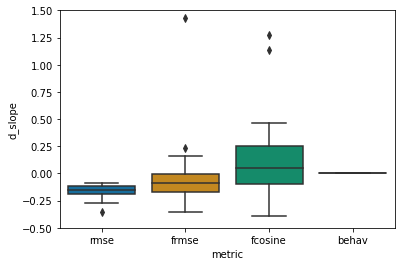

In [108]:
sns.boxplot(x='metric', y='d_slope', data=normalized_df)
plt.ylim([-.5, 1.5])

<AxesSubplot:xlabel='metric', ylabel='d_inflection'>

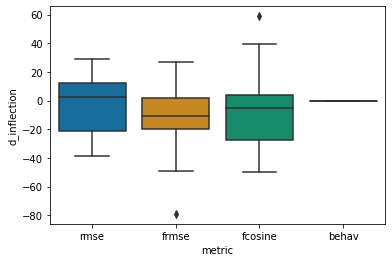

In [85]:
sns.boxplot(x='metric', y='d_inflection', data=normalized_df)
# plt.ylim([-.5, 1.5])

In [120]:
model = smf.mixedlm("d_slope ~ C(metric, Treatment('behav'))",
                    normalized_df,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                       MixedLM          Dependent Variable:          d_slope 
No. Observations:            159              Method:                      REML    
No. Groups:                  3                Scale:                       0.0109  
Min. group size:             49               Log-Likelihood:              120.3230
Max. group size:             59               Converged:                   Yes     
Mean group size:             53.0                                                  
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                -0.000    0.030 -0.000 1.000 -0.058  0.058
C(metric, Treatment('behav'))[T.fcosine]  0.011    0.024  0.464 0.642 -0.035  0.057
C(metric, Treatment('behav'))[T.frmse]   -0.091    0.023 -3.964 0.000 -0.136 -0.046
C(metric, Treatment('behav'))[T.rmse]    -0.171    0.022 -7.701 0.000 -0.215 -0.128
group Var                                 0.002    0.021                           
===================================================================================

"""

In [121]:
model = smf.mixedlm("d_inflection ~ C(metric, Treatment('behav'))",
                    normalized_df,
                    groups= "group").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM         Dependent Variable:         d_inflection
No. Observations:           159             Method:                     REML        
No. Groups:                 3               Scale:                      261.7021    
Min. group size:            49              Log-Likelihood:             -660.2101   
Max. group size:            59              Converged:                  Yes         
Mean group size:            53.0                                                    
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 0.000    3.317  0.000 1.000  -6.501  6.501
C(metric, Treatment('behav'))[T.fcosine] -8.544    3.660 -2.335 0.020 -15.717 -1.371
C(metric, Treatment('behav'))[T.frmse]   -9.123    3.547 -2.572 0.010 -16.075 -2.172
C(metric, Treatment('behav'))[T.rmse]    -3.033    3.444 -0.881 0.378  -9.783  3.716
group Var                                16.652    1.343                            
====================================================================================

"""